# Flight Delay Analysis and Prediction


## By Dong Zhang


## 1. Introduction

Most people have flight delay experiences. Sometimes flight delays (including cancellations) can be a really big issue, especially for business trips or emergency flights. Flight delays are caused by various reasons, also depend on flight companies and airports. In this project, I try to classify and predict flight delays using machine learning techniques. I use the data of flight delays downloaded from the Bureau of Transportation Statistics. More data are required for better prediction.  

### Data 

The dataset is from the Bureau of Transportation Statistics:
https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp?pn=1

Data is collected between June, 2003 to Feb, 2019, from all airports and airlines in the US. Flight delays can be caused by different reasons, including Air Carrier Delay, Weather Delay, National Aviation System (NAS) Delay, Security Delay, Aircraft Arriving Delay, Cancellation and Diverted. The definitions of the variety of delays can be see here:
https://www.bts.dot.gov/explore-topics-and-geography/topics/airline-time-performance-and-causes-flight-delays

Each row of the data shows the number of total flights, the number of each type of delays, and the duration (in minutes) of each delay for an individual flight airline in an individual airports in one month. So this is not the raw data, but we can still learning much information from the data. Eventually, my goal is to predict the probability and waiting time of each delay cause. For this project, I take American Airline and Atlanta Airport (ATL) for case studies, compare them with the overall flight performance in the US. Then given the parameter set of year and month, I predict flight delays for AA/ATL. 

Other data includes the longitudes and latitudes of airports in the US (airport.csv). In future I will collect more data including not only the information by years and months, but also dates and hours. More data can be collected here:
https://transtats.bts.gov/ONTIME/Departures.aspx

In current stages, the data already shows many interesting results. 


### Tools

-- **Language**: Python, with packages pandas, seaborn, numpy, etc.

-- **Visualization**: matplotlib, basemap

-- **Machine Learning**: scikit-learn package. Classification: Logistic, Random Forest, k-Nearest Neighbors, Decision Tree, Support Vector Machine (SVM), Gaussian Process. Regression: Linear, Polynomial, Regularization, SVM, BayesianRidge


### Content

This notebook includes five parts. The brief summary is as follows. 

**1. Loading and Cleaning Data** 

I use two csv files, then remove null data. 

**2. Delays on the Map and Delay Classification**

I use basemap to show the flight performance in individual airports all over the US, by computing the averaged delay rate (percentage), averaged delay time in every airport. According to the distribution of delay rates in the US, I sort all airports into several groups, then use **supervised ML classification** techniques to classify the US territory into several groups according to flight performance: worst, bad, moderate, and fine. 

**3. Comparison of Averaged Flight Performance to Individual Airport/Airline**

Averaged Delay Probabilities and Durations are calculated by years and months. Curves of Delay Performance vs Years/Months are plotted. Linear and Polynomial Regression methods are used to fit the Delay performance curves. Then the averaged flight performance is compared to individual airport/airline, in particular, the AA airline and ATL airport. 

**4. Supervised Regression and Classification for Individual Airport/Airline ** 

Data is extracted from the total data, only for AA, or ATL. Given the parameter set of year and month, I would like to predict the delay rate, both as continuous numbers, and classified levels/groups. So I use both supervised regression and classification methods. Data is divided into training and testing parts, several regression/classification methods are compared and scored. 

**5. Discussion and Future Work**

The results obtained by data analysis need to be further explored. More data will be collected to improve the accuracy of prediction. Also deep learning techinques can be used for better prediction. 

Now let us go into details.



## Part 1: Data Loading and Cleaning


In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('airline_delay.csv')
print(data.shape)
data.head(5)

(256285, 21)


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2003,6,AA,American Airlines Inc.,ABQ,"Albuquerque, NM: Albuquerque International Sun...",307.0,56.0,14.68,10.79,...,1.48,9.96,1.0,1.0,2530.0,510.0,621.0,676.0,25.0,698.0
1,2003,6,AA,American Airlines Inc.,ANC,"Anchorage, AK: Ted Stevens Anchorage Internati...",90.0,27.0,7.09,2.00,...,0.00,7.16,0.0,0.0,1390.0,271.0,83.0,581.0,0.0,455.0
2,2003,6,AA,American Airlines Inc.,ATL,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",752.0,186.0,33.99,27.82,...,1.90,17.53,5.0,0.0,8314.0,1367.0,1722.0,3817.0,139.0,1269.0
3,2003,6,AA,American Airlines Inc.,AUS,"Austin, TX: Austin - Bergstrom International",842.0,174.0,60.24,20.54,...,4.69,40.75,9.0,1.0,8344.0,3040.0,1032.0,1835.0,115.0,2322.0
4,2003,6,AA,American Airlines Inc.,BDL,"Hartford, CT: Bradley International",383.0,55.0,14.90,8.91,...,0.00,16.61,0.0,0.0,3137.0,815.0,574.0,555.0,0.0,1193.0


In [2]:
pd.concat([data.isnull().sum(), 100 * data.isnull().sum()/len(data)], 
              axis=1).rename(columns={0:'Missing Data', 1:'Percentage (%)'})

,Missing Data,Percentage (%)
year,0,0.000000
month,0,0.000000
carrier,0,0.000000
carrier_name,0,0.000000
airport,0,0.000000
airport_name,0,0.000000
arr_flights,362,0.141249
arr_del15,416,0.162319
carrier_ct,362,0.141249
weather_ct,362,0.141249


In [3]:
data.dropna(inplace = True)


## Part 2: First Visualization and Classification


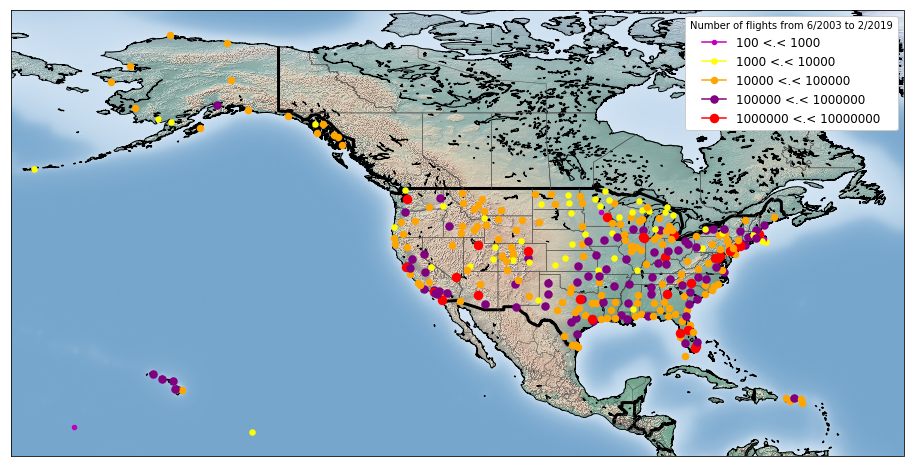

In [4]:
from collections import OrderedDict
from mpl_toolkits.basemap import Basemap

airports = pd.read_csv("airports.csv")

#count_flights = data['airport'].value_counts()
count_flights = data.groupby('airport', as_index=False).agg({'arr_flights': 'sum'})

plt.figure(figsize=(16,16))
#________________________________________
# define properties of markers and labels
colors = ['lightblue', 'm','yellow', 'orange', 'purple', 'red' ]
size_limits = [1, 100, 1000, 10000, 100000, 1000000, 10000000]
labels = []
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1])) 
#____________________________________________________________
map = Basemap(resolution='i',llcrnrlon=-180, urcrnrlon=-50,
              llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0,)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color='0.3')
#_____________________
# put airports on map
for index, (code, y,x) in airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
    x, y = map(x, y)
    val0 = count_flights[count_flights.airport==code].arr_flights.item()
    isize = [i for i, val in enumerate(size_limits) if val < val0]
    ind = isize[-1]
    map.plot(x, y, marker='o', markersize = ind+3, 
             markeredgewidth = 1.5, color = colors[ind], label = labels[ind])

#_____________________________________________
# remove duplicate labels and set their order
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('100 <.< 1000', '1000 <.< 10000'
             ,'10000 <.< 100000', '100000 <.< 1000000', '1000000 <.< 10000000')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label[key]
    #print(key,by_label[key])
plt.legend(new_label.values(), new_label.keys(), loc = 'best', prop= {'size':12},
           title='Number of flights from 6/2003 to 2/2019', frameon = True, framealpha = 1)
plt.show()

**Discussion for the Above Figure:** The total number of flights are sum up for individual airports, and distributed on the US map. Tens of airports (red dots) are very busy, among them ATL and ORD are the busiest. The data from ATL and AA will be collected for case studies. 


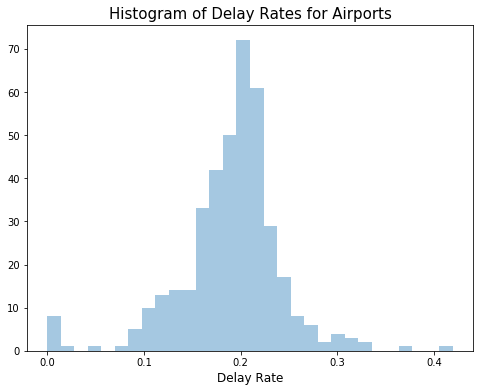

In [5]:
count_delays = data.groupby('airport', as_index=False).agg({'arr_del15': 'sum'})

count_delays['delay_rate'] = count_delays['arr_del15']/count_flights['arr_flights']
count_delays = count_delays[count_delays['delay_rate'] < 1.0]

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.distplot(count_delays['delay_rate'],bins=30,kde=False)
ax.set_title('Histogram of Delay Rates for Airports',size='15')
ax.set_xlabel('Delay Rate',size='12')
plt.show()

**Discussion for the Above Figure:** The **Averaged Delay Rate** in a single airport (total number of flight delays: total number of flights) is calculated and shown as a statistic histogram. We find that delay rates are peaked around 0.2 (20%), which means most airports have $\sim\,$20% delay rate. More sophisticated analysis is following.

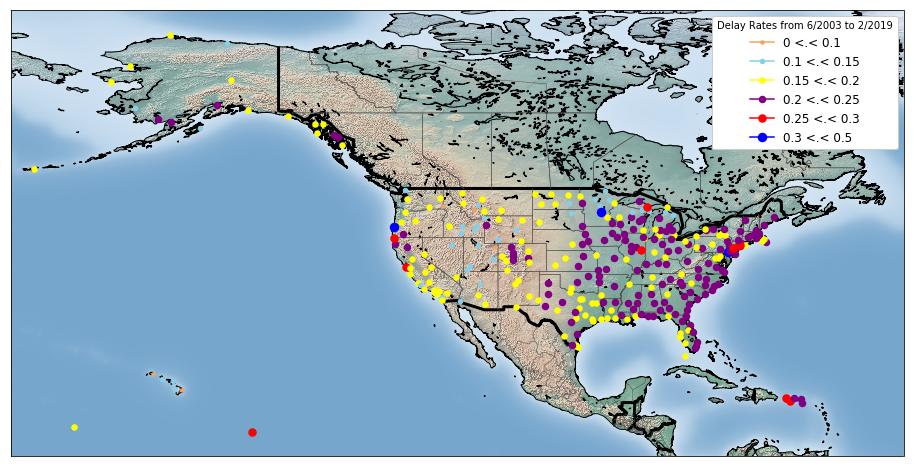

In [6]:
plt.figure(figsize=(16,16))
#________________________________________
# define properties of markers and labels
colors = ['sandybrown','skyblue', 'yellow', 'purple', 'red','blue' ]
size_limits = [0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5]
labels = []
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1]))

#labels

#____________________________________________________________
map = Basemap(resolution='i',llcrnrlon=-180, urcrnrlon=-50,
              llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0,)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color='0.3')

for index, (code, y,x) in airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
    x, y = map(x, y)
    val0 = count_delays[count_delays.airport==code].delay_rate.item()
    isize = [i for i, val in enumerate(size_limits) if val < val0]
    ind = isize[-1]
    map.plot(x, y, marker='o', markersize = ind+3, 
             markeredgewidth = 1.5, color = colors[ind], label = labels[ind])
    #print(index,val0,isize)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))

#print(by_label)

key_order = ('0 <.< 0.1', '0.1 <.< 0.15','0.15 <.< 0.2', 
             '0.2 <.< 0.25','0.25 <.< 0.3', '0.3 <.< 0.5')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label[key]
    #print(key,by_label[key])

plt.legend(new_label.values(), new_label.keys(), loc = 'best', prop= {'size':12},
           title='Delay Rates from 6/2003 to 2/2019', frameon = True, framealpha = 1)
plt.show()

**Discussion for the Above Map:** The Averaged Delay Rate in each airport is distributed on the map as one dot. Interestingly, we find that the flight performance is better in the West compared to the East. A more elaborate classification is needed. 


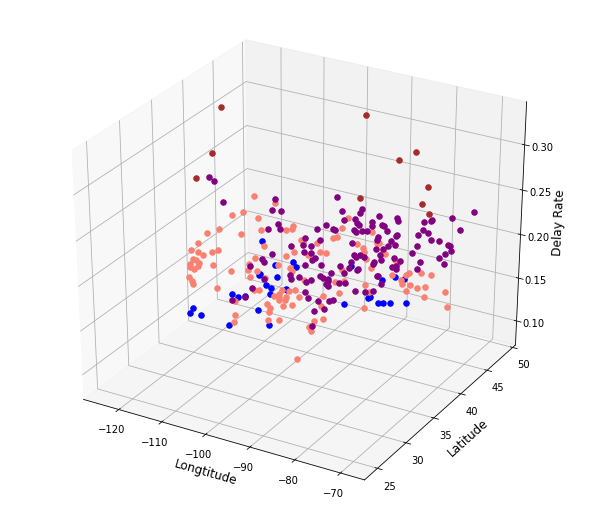

In [7]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,7))
#________________________________________
# define properties of markers and labels
colors = ['blue', 'salmon', 'purple', 'brown']
size_limits = [0, 0.15, 0.2, 0.25, 0.5]
labels = []
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1]))

ax = Axes3D(fig)
ax.set_xlabel('Longtitude',size=12)
ax.set_ylabel('Latitude',size=12)
ax.set_zlabel('Delay Rate',size=12)

Sort_X = []
Sort_Y = []

for index, (code, y,x) in airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
    if (x>-130 and x<-50 and y > 20 and y< 60):
        x, y = map(x, y)
        val0 = count_delays[count_delays.airport==code].delay_rate.item()
        Sort_X.append([x,y])
        isize = [i for i, val in enumerate(size_limits) if val < val0]
        ind = isize[-1]
        Sort_Y.append(ind)
        ax.scatter(x, y, val0, marker='o', s=30, color = colors[ind])

Sort_X = np.array(Sort_X)
Sort_Y = np.array(Sort_Y)

**Discussion for the Above 3D Figure:** Delay Rates are classified into four groups: <0.15 (Fine), 0.15 - 0.2 (Moderate), 0.2-0.25 (Bad), 0.25 - 0.5 (Worst). An extra dimension is introduced for groups. A 3D Figure is better to show the data with two features (longtitude and latitude), and one characteristic classification (level). Now I introduce machine learning classifiers. 

Random Forest Accuracy: 0.9722222222222222
K-Nearest Neighbors Accuracy: 0.7604166666666666
Decision Tree Accuracy: 0.9618055555555556
Gaussian Process Accuracy: 0.9027777777777778


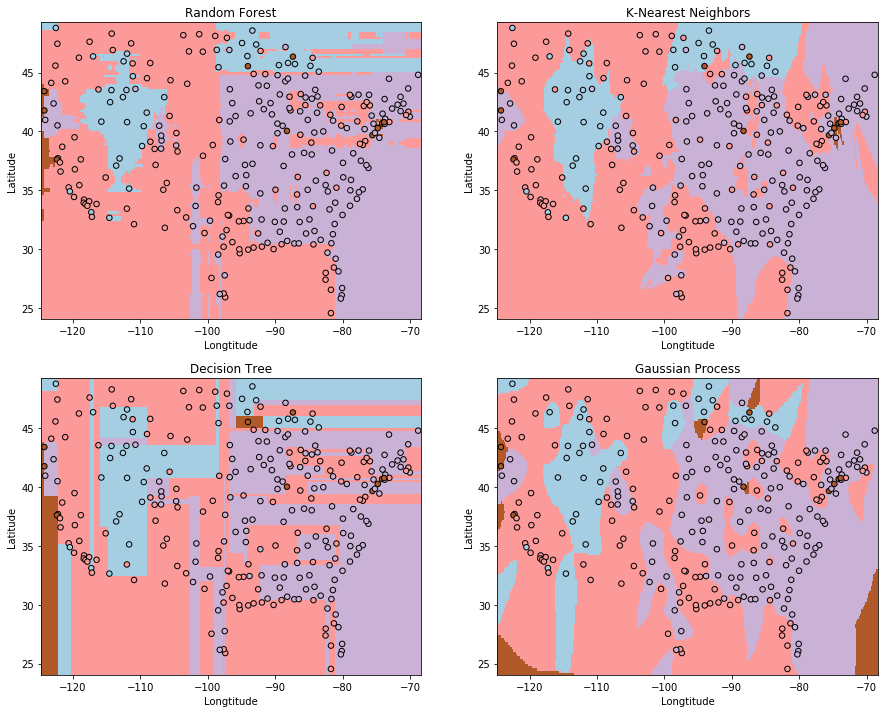

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.metrics import accuracy_score

X = Sort_X
Y = Sort_Y

h = 0.2
x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
y_min, y_max = X[:,1].min() - .5, X[:,1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

models = (RandomForestClassifier(n_estimators=200,min_samples_split=5),
          KNeighborsClassifier(n_neighbors=5),
          DecisionTreeClassifier(min_samples_split=3,random_state=10),
          GaussianProcessClassifier(random_state=10))
models = (clf.fit(X, Y) for clf in models)

titles = ('Random Forest','K-Nearest Neighbors','Decision Tree','Gaussian Process')

fig = plt.figure(figsize=(15,12))
panels = [fig.add_subplot(221),fig.add_subplot(222),fig.add_subplot(223),fig.add_subplot(224)]

for clf, title, ax in zip(models, titles, panels):
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    acc = accuracy_score(Y, clf.predict(X))
    print(title + ' Accuracy:', acc)
    Z = Z.reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z,cmap=plt.cm.Paired)
    ax.scatter(X[:,0], X[:,1],c=Y,cmap=plt.cm.Paired, s=30, edgecolors='k')
    ax.set_xlabel('Longtitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

**Discussion for the Above Figure:** Using the sklearn Random Forest, KNN, Decision Tree and Gaussian Process Classifiers, we classify the US land (no Alaska, Hawaii and Puerto Rico, sorry!) into several areas depending on the flight performance: Worst (brown), Bad (light purple), Moderate (pink), and Fine (light blue).  

**Comments on the Classification:** 

We use the accuracy_score function from sklearn.metrics to evaluate four classifications. We find that Random Forest, Decision Tree and Gaussian Process give accuracy higher than **> 90%**, which is pretty good. Note that we do not split the data into testing and traing parts, so the scores are only for the set of training data. On the other hand, the boundaries given by Random Forest and Decision Tree are less smooth than those given by KNN or Gaussian Process (Random Forest may still be okay, but Decision Tree gives weird boundaries!). From this point of view, KNN and Gaussian Process are better than Decision Tree, while Random Forest still looks fine.  My **First Conclusion** is that, Gaussian Process is are better than other classification methods for this problem, while Random Forest is also good. 


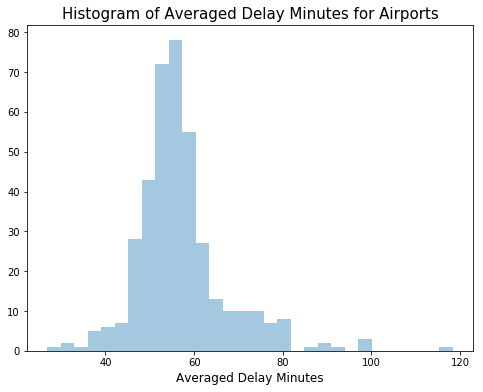

In [9]:
data_temp = data.groupby('airport', as_index=False).agg({'arr_delay': 'sum'})
count_delays['delay_min']=data_temp['arr_delay']/count_delays['arr_del15']

count_delays = count_delays[count_delays['delay_min'] < 120.0]

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.distplot(count_delays['delay_min'],bins=30,kde=False)
ax.set_title('Histogram of Averaged Delay Minutes for Airports',size='15')
ax.set_xlabel('Averaged Delay Minutes',size='12')
plt.show()

Then we study the **Averaged Delay Minutes** in each airport (total delay minutes to the total number of delay flights in each airport). The histogram shows the statistics of delay performance for all airports. Most delays are around one hour. Next we study the averaged delay duration in each airport distributed on the US map. 


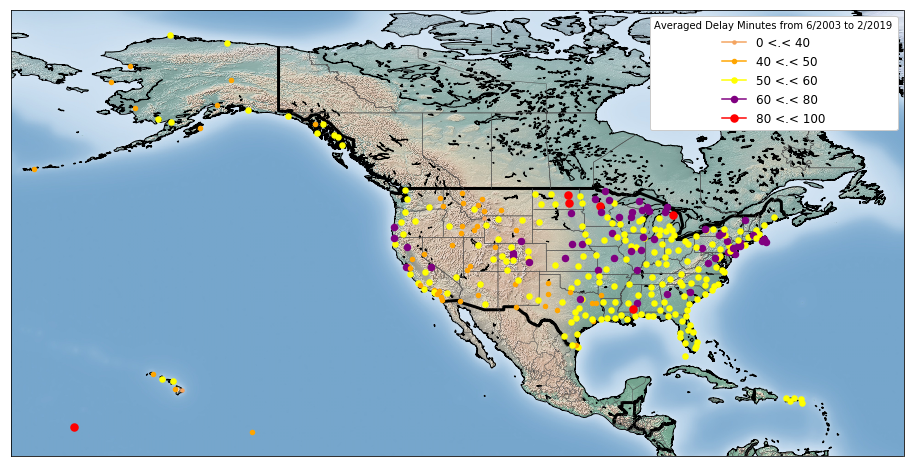

In [10]:
plt.figure(figsize=(16,16))
#________________________________________
# define properties of markers and labels
colors = ['sandybrown','orange', 'yellow', 'purple', 'red','blue' ]
size_limits = [0, 40, 50, 60, 80, 100, 120]
labels = []
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1]))

labels

#____________________________________________________________
map = Basemap(resolution='i',llcrnrlon=-180, urcrnrlon=-50,
              llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0,)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color='0.3')

for index, (code, y,x) in airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
    x, y = map(x, y)
    val0 = count_delays[count_delays.airport==code].delay_min.item()
    isize = [i for i, val in enumerate(size_limits) if val < val0]
    ind = isize[-1]
    map.plot(x, y, marker='o', markersize = ind+3, 
             markeredgewidth = 1.5, color = colors[ind], label = labels[ind])
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))

#print(by_label)

key_order = ('0 <.< 40', '40 <.< 50','50 <.< 60', 
             '60 <.< 80','80 <.< 100')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label[key]
    #print(key,by_label[key])

plt.legend(new_label.values(), new_label.keys(), loc = 'best', prop= {'size':12},
           title='Averaged Delay Minutes from 6/2003 to 2/2019', frameon = True, framealpha = 1)
plt.show()

Again, it shows that the delay duration is typically shorter in some West area. Mostly, the typical delay duration is **50 - 60 minutes**. I skip the classification work. Now we go to the third part. 


## Part 3. Comparison of Averaged Flight Performance (by year or month) to Individual Airport/Airline

### 3.1. Delay Rates vs Years


Carrier Linear Score: 0.020093147799164268
Carrier Linear AA Score: -0.5023143830695236
Carrier Linear ATL Score: -2.0600789069839975

NAS Linear Score: 0.46378927417979876
NAS Linear AA Score: -0.11007067496092371
NAS Linear ATL Score: 0.07002860494690344

Latecraft Linear Score: 0.10351660568906929
Latecraft Linear AA Score: -0.158307231332254
Latecraft Linear ATL Score: -0.7672761380681956


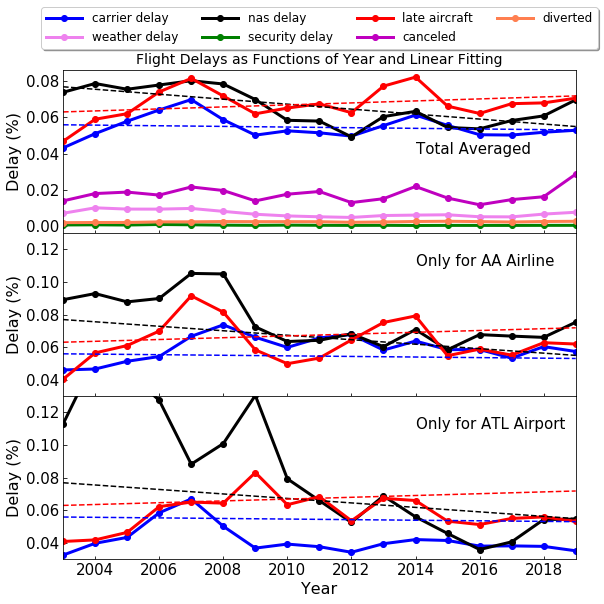

In [11]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

year_delays = data.groupby('year', as_index=False).sum()


X1 = year_delays['year'].values
Y_deltot  = year_delays['arr_del15'].values/year_delays['arr_flights'].values
Y_carrier = year_delays['carrier_ct'].values/year_delays['arr_flights'].values
Y_weather = year_delays['weather_ct'].values/year_delays['arr_flights'].values
Y_nas = year_delays['nas_ct'].values/year_delays['arr_flights'].values
Y_security = year_delays['security_ct'].values/year_delays['arr_flights'].values
Y_latecraft = year_delays['late_aircraft_ct'].values/year_delays['arr_flights'].values
Y_cancelled = year_delays['arr_cancelled'].values/year_delays['arr_flights'].values
Y_diverted = year_delays['arr_diverted'].values/year_delays['arr_flights'].values

data_AA = data[data['carrier'].str.contains('AA')]
year_delays_AA = data_AA.groupby('year', as_index=False).sum()
Y_carrier_AA = year_delays_AA['carrier_ct'].values/year_delays_AA['arr_flights'].values
Y_nas_AA = year_delays_AA['nas_ct'].values/year_delays_AA['arr_flights'].values
Y_latecraft_AA = year_delays_AA['late_aircraft_ct'].values/year_delays_AA['arr_flights'].values

data_ATL = data[data['airport'].str.contains('ATL')]
year_delays_ATL = data_ATL.groupby('year', as_index=False).sum()
Y_carrier_ATL = year_delays_ATL['carrier_ct'].values/year_delays_ATL['arr_flights'].values
Y_nas_ATL = year_delays_ATL['nas_ct'].values/year_delays_ATL['arr_flights'].values
Y_latecraft_ATL = year_delays_ATL['late_aircraft_ct'].values/year_delays_ATL['arr_flights'].values

linear = linear_model.LinearRegression()
X_fit = year_delays.filter(regex='year').values
linear.fit(X_fit,Y_carrier)
Y_carrier_pred = linear.predict(X_fit)
print("Carrier Linear Score:", linear.score(X_fit,Y_carrier))
print("Carrier Linear AA Score:", linear.score(X_fit,Y_carrier_AA))
print("Carrier Linear ATL Score:", linear.score(X_fit,Y_carrier_ATL))

linear.fit(X_fit,Y_nas)
Y_nas_pred = linear.predict(X_fit)
print("\nNAS Linear Score:", linear.score(X_fit,Y_nas))
print("NAS Linear AA Score:", linear.score(X_fit,Y_nas_AA))
print("NAS Linear ATL Score:", linear.score(X_fit,Y_nas_ATL))

linear.fit(X_fit,Y_latecraft)
Y_latecraft_pred = linear.predict(X_fit)
print("\nLatecraft Linear Score:", linear.score(X_fit,Y_latecraft))
print("Latecraft Linear AA Score:", linear.score(X_fit,Y_latecraft_AA))
print("Latecraft Linear ATL Score:", linear.score(X_fit,Y_latecraft_ATL))


fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(311)

ax1.plot(X1,Y_carrier,'-o',linewidth=3,color='blue')
ax1.plot(X1,Y_weather,'-o',linewidth=3,color='violet')
ax1.plot(X1,Y_nas,'-o',linewidth=3,color='black')
ax1.plot(X1,Y_security,'-o',linewidth=3,color='green')
ax1.plot(X1,Y_latecraft,'-o',linewidth=3,color='red')
ax1.plot(X1,Y_cancelled,'-o',linewidth=3,color='m')
ax1.plot(X1,Y_diverted,'-o',linewidth=3,color='coral')
ax1.plot(X1,Y_carrier_pred,'--',linewidth=1.5,color='blue')
ax1.plot(X1,Y_nas_pred,'--',linewidth=1.5,color='black')
ax1.plot(X1,Y_latecraft_pred,'--',linewidth=1.5,color='red')
ax1.tick_params(labelsize=15,direction='in')
ax1.legend(['carrier delay','weather delay','nas delay','security delay','late aircraft','canceled','diverted'], 
           fontsize=12,handlelength=3,frameon=True,loc='upper center', bbox_to_anchor=(0.5, 1.42),
           fancybox=True, shadow=True, ncol=4)
plt.setp(ax1.get_xticklabels(),visible=False)
ax1.set_ylabel('Delay (%)',fontsize=16)
ax1.set_xlim([2003,2019])
plt.title('Flight Delays as Functions of Year and Linear Fitting',fontsize=14)

plt.subplots_adjust(hspace=0)

ax2 = fig.add_subplot(312)
ax2.plot(X1,Y_carrier_AA,'-o',linewidth=3,color='blue')
ax2.plot(X1,Y_nas_AA,'-o',linewidth=3,color='black')
ax2.plot(X1,Y_latecraft_AA,'-o',linewidth=3,color='red')
ax2.plot(X1,Y_carrier_pred,'--',linewidth=1.5,color='blue')
ax2.plot(X1,Y_nas_pred,'--',linewidth=1.5,color='black')
ax2.plot(X1,Y_latecraft_pred,'--',linewidth=1.5,color='red')
ax2.tick_params(labelsize=15,direction='in')
plt.setp(ax2.get_xticklabels(),visible=False)
ax2.set_ylabel('Delay (%)',fontsize=16)
ax2.set_xlim([2003,2019])
ax2.set_ylim([0.03,0.13])

plt.subplots_adjust(hspace=0)


ax3 = fig.add_subplot(313)
ax3.plot(X1,Y_carrier_ATL,'-o',linewidth=3,color='blue')
ax3.plot(X1,Y_nas_ATL,'-o',linewidth=3,color='black')
ax3.plot(X1,Y_latecraft_ATL,'-o',linewidth=3,color='red')
ax3.plot(X1,Y_carrier_pred,'--',linewidth=1.5,color='blue')
ax3.plot(X1,Y_nas_pred,'--',linewidth=1.5,color='black')
ax3.plot(X1,Y_latecraft_pred,'--',linewidth=1.5,color='red')
ax3.tick_params(labelsize=15,direction='in')
#plt.setp(ax3.get_xticklabels(),visible=False)
ax3.set_xlabel('Year',fontsize=16)
ax3.set_ylabel('Delay (%)',fontsize=16)
ax3.set_xlim([2003,2019])
ax3.set_ylim([0.03,0.13])

ax1.annotate('Total Averaged', xy=(2014,0.04),fontsize=15)
ax2.annotate('Only for AA Airline', xy=(2014,0.11),fontsize=15)
ax3.annotate('Only for ATL Airport', xy=(2014,0.11),fontsize=15)

fig.subplots_adjust(left=0.08,right=0.97,bottom=0.05,top=0.9)


plt.show()
#year_delays

**Discussion for the Above Figure:** 

I sum up the number of total flights, of various delays (seven causes) by **years**. For each year, the **Averaged Delay Rate** is defined as the ratio of the number of each delay causes to the number of total fights. Then the averaged delay rates are plotted as the upper panel. We find that carrier, nas and weather delays dominate over other causes. In this figure, I simply use linear regression to fit the curves of delay rates vs. years. The lines are also plotted in the middle and lower panels, which are plotted for a single airline (American Airline) and a single airport (ATL) respectively. Obviously, the fitting lines obtained from the total data do not work neither for AA nor for ATL. For example, the blue dashed line is below the actual AA data, which means that the performance of AA carrier delay is below average. Also, the NAS delay of AA earlier than 2010 is also below average. The performance of NAS delay at ATL is far below average for years earlier than 2010, but much improved in recent years. Both the carrier and late-aircraft delays at ATL are better than the averaged data (blue and red lines). 

Quantitatively, the differences between the averaged data and individual airport/airline are measured by **linear.score**.

The reasons behind the phenomena is worthwhile to be discussed. 


Carrier Poly Score: 0.30948036350203956
Carrier Poly AA Score: -0.06640631119382756
Carrier Poly ATL Score: -1.8320479514346446

NAS Poly Score: 0.8000332197280068
NAS Poly AA Score: 0.09924913719884809
NAS Poly ATL Score: 0.13656857493973773

Latecraft Poly Score: 0.41042010918103333
Latecraft Poly AA Score: 0.09026058301755191
Latecraft Poly ATL Score: -0.2614501431568521


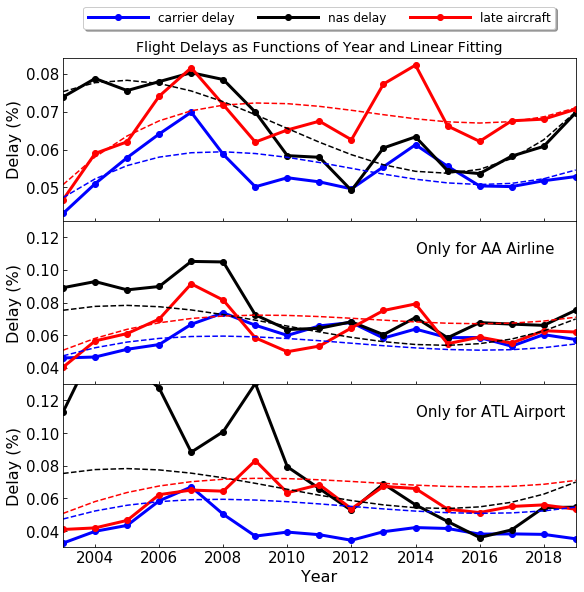

In [12]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3)
X_fit_ = poly.fit_transform(X_fit)

linear.fit(X_fit_,Y_carrier)
Y_carrier_pred_ = linear.predict(X_fit_)
print("Carrier Poly Score:", linear.score(X_fit_,Y_carrier))
print("Carrier Poly AA Score:", linear.score(X_fit_,Y_carrier_AA))
print("Carrier Poly ATL Score:", linear.score(X_fit_,Y_carrier_ATL))

linear.fit(X_fit_,Y_nas)
Y_nas_pred_ = linear.predict(X_fit_)
print("\nNAS Poly Score:", linear.score(X_fit_,Y_nas))
print("NAS Poly AA Score:", linear.score(X_fit_,Y_nas_AA))
print("NAS Poly ATL Score:", linear.score(X_fit_,Y_nas_ATL))

linear.fit(X_fit_,Y_latecraft)
Y_latecraft_pred_ = linear.predict(X_fit_)
print("\nLatecraft Poly Score:", linear.score(X_fit_,Y_latecraft))
print("Latecraft Poly AA Score:", linear.score(X_fit_,Y_latecraft_AA))
print("Latecraft Poly ATL Score:", linear.score(X_fit_,Y_latecraft_ATL))



fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(311)

ax1.plot(X1,Y_carrier,'-o',linewidth=3,color='blue')
ax1.plot(X1,Y_nas,'-o',linewidth=3,color='black')
ax1.plot(X1,Y_latecraft,'-o',linewidth=3,color='red')
ax1.plot(X1,Y_carrier_pred_,'--',linewidth=1.5,color='blue')
ax1.plot(X1,Y_nas_pred_,'--',linewidth=1.5,color='black')
ax1.plot(X1,Y_latecraft_pred_,'--',linewidth=1.5,color='red')
ax1.tick_params(labelsize=15,direction='in')
ax1.legend(['carrier delay','nas delay','late aircraft'], 
           fontsize=12,handlelength=5,frameon=True,loc='upper center', bbox_to_anchor=(0.5, 1.35),
           fancybox=True, shadow=True, ncol=4)
plt.setp(ax1.get_xticklabels(),visible=False)
ax1.set_ylabel('Delay (%)',fontsize=16)
ax1.set_xlim([2003,2019])
plt.title('Flight Delays as Functions of Year and Linear Fitting',fontsize=14)

plt.subplots_adjust(hspace=0)

ax2 = fig.add_subplot(312)
ax2.plot(X1,Y_carrier_AA,'-o',linewidth=3,color='blue')
ax2.plot(X1,Y_nas_AA,'-o',linewidth=3,color='black')
ax2.plot(X1,Y_latecraft_AA,'-o',linewidth=3,color='red')
ax2.plot(X1,Y_carrier_pred_,'--',linewidth=1.5,color='blue')
ax2.plot(X1,Y_nas_pred_,'--',linewidth=1.5,color='black')
ax2.plot(X1,Y_latecraft_pred_,'--',linewidth=1.5,color='red')
ax2.tick_params(labelsize=15,direction='in')
plt.setp(ax2.get_xticklabels(),visible=False)
ax2.set_ylabel('Delay (%)',fontsize=16)
ax2.set_xlim([2003,2019])
ax2.set_ylim([0.03,0.13])

plt.subplots_adjust(hspace=0)


ax3 = fig.add_subplot(313)
ax3.plot(X1,Y_carrier_ATL,'-o',linewidth=3,color='blue')
ax3.plot(X1,Y_nas_ATL,'-o',linewidth=3,color='black')
ax3.plot(X1,Y_latecraft_ATL,'-o',linewidth=3,color='red')
ax3.plot(X1,Y_carrier_pred_,'--',linewidth=1.5,color='blue')
ax3.plot(X1,Y_nas_pred_,'--',linewidth=1.5,color='black')
ax3.plot(X1,Y_latecraft_pred_,'--',linewidth=1.5,color='red')
ax3.tick_params(labelsize=15,direction='in')
#plt.setp(ax3.get_xticklabels(),visible=False)
ax3.set_xlabel('Year',fontsize=16)
ax3.set_ylabel('Delay (%)',fontsize=16)
ax3.set_xlim([2003,2019])
ax3.set_ylim([0.03,0.13])

ax1.annotate('Total Averaged', xy=(2014,0.04),fontsize=15)
ax2.annotate('Only for AA Airline', xy=(2014,0.11),fontsize=15)
ax3.annotate('Only for ATL Airport', xy=(2014,0.11),fontsize=15)

fig.subplots_adjust(left=0.08,right=0.97,bottom=0.05,top=0.9)


plt.show()

**Discussion for the Above Figure:** This Figure is similar to the last figure, but I use polynomial fitting instead of linear fitting for the averaged data. One can see that the fitting scores for the averaged data is better than those in the last figure. However, similar conclusions (see the discussion for the last figure) can also be obtained from the middle and lower panels. 

### 3.2 Delay Rates vs Months


Carrier Poly Score: 0.8622802887748304
Carrier Poly AA Score: 0.38122312889878807
Carrier Poly ATL Score: -3.7455591678416758

NAS Poly Score: 0.8636365187852908
NAS Poly AA Score: -1.1223257201510832
NAS Poly ATL Score: -3.8913468509614506

Latecraft Poly Score: 0.8525360027517014
Latecraft Poly AA Score: 0.5808271086236309
Latecraft Poly ATL Score: -0.15785040959352958


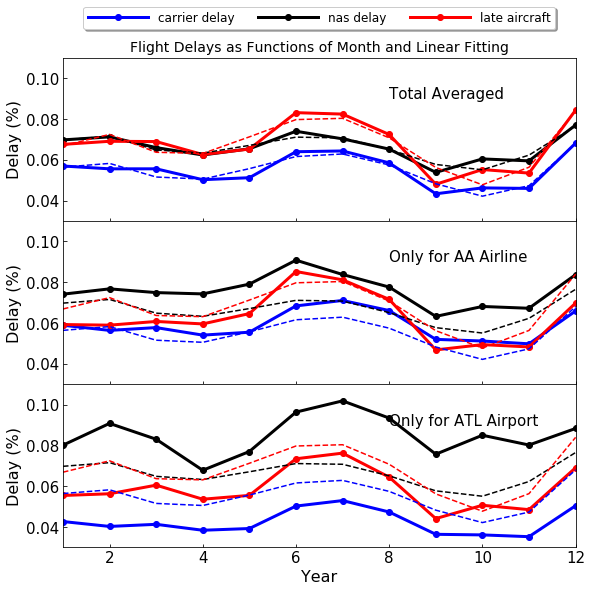

In [13]:
month_delays = data.groupby('month', as_index=False).sum()


Xm = month_delays['month'].values
Ym_deltot  = month_delays['arr_del15'].values/month_delays['arr_flights'].values
Ym_carrier = month_delays['carrier_ct'].values/month_delays['arr_flights'].values
Ym_weather = month_delays['weather_ct'].values/month_delays['arr_flights'].values
Ym_nas = month_delays['nas_ct'].values/month_delays['arr_flights'].values
Ym_security  = month_delays['security_ct'].values/month_delays['arr_flights'].values
Ym_latecraft = month_delays['late_aircraft_ct'].values/month_delays['arr_flights'].values
Ym_cancelled = month_delays['arr_cancelled'].values/month_delays['arr_flights'].values
Ym_diverted  = month_delays['arr_diverted'].values/month_delays['arr_flights'].values

data_AA = data[data['carrier'].str.contains('AA')]
month_delays_AA = data_AA.groupby('month', as_index=False).sum()
Ym_carrier_AA = month_delays_AA['carrier_ct'].values/month_delays_AA['arr_flights'].values
Ym_nas_AA = month_delays_AA['nas_ct'].values/month_delays_AA['arr_flights'].values
Ym_latecraft_AA = month_delays_AA['late_aircraft_ct'].values/month_delays_AA['arr_flights'].values

data_AA = data[data['airport'].str.contains('ATL')]
month_delays_ATL = data_ATL.groupby('month', as_index=False).sum()
Ym_carrier_ATL = month_delays_ATL['carrier_ct'].values/month_delays_ATL['arr_flights'].values
Ym_nas_ATL = month_delays_ATL['nas_ct'].values/month_delays_ATL['arr_flights'].values
Ym_latecraft_ATL = month_delays_ATL['late_aircraft_ct'].values/month_delays_ATL['arr_flights'].values

Xm_fit = month_delays.filter(regex='month').values
poly = PolynomialFeatures(degree=6)
Xm_fit_ = poly.fit_transform(Xm_fit)

linear.fit(Xm_fit_,Ym_carrier)
Ym_carrier_pred_ = linear.predict(Xm_fit_)
print("Carrier Poly Score:", linear.score(Xm_fit_,Ym_carrier))
print("Carrier Poly AA Score:", linear.score(Xm_fit_,Ym_carrier_AA))
print("Carrier Poly ATL Score:", linear.score(Xm_fit_,Ym_carrier_ATL))

linear.fit(Xm_fit_,Ym_nas)
Ym_nas_pred_ = linear.predict(Xm_fit_)
print("\nNAS Poly Score:", linear.score(Xm_fit_,Ym_nas))
print("NAS Poly AA Score:", linear.score(Xm_fit_,Ym_nas_AA))
print("NAS Poly ATL Score:", linear.score(Xm_fit_,Ym_nas_ATL))

linear.fit(Xm_fit_,Ym_latecraft)
Ym_latecraft_pred_ = linear.predict(Xm_fit_)
print("\nLatecraft Poly Score:", linear.score(Xm_fit_,Ym_latecraft))
print("Latecraft Poly AA Score:", linear.score(Xm_fit_,Ym_latecraft_AA))
print("Latecraft Poly ATL Score:", linear.score(Xm_fit_,Ym_latecraft_ATL))


fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(311)

ax1.plot(Xm,Ym_carrier,'-o',linewidth=3,color='blue')
ax1.plot(Xm,Ym_nas,'-o',linewidth=3,color='black')
ax1.plot(Xm,Ym_latecraft,'-o',linewidth=3,color='red')
ax1.plot(Xm,Ym_carrier_pred_,'--',linewidth=1.5,color='blue')
ax1.plot(Xm,Ym_nas_pred_,'--',linewidth=1.5,color='black')
ax1.plot(Xm,Ym_latecraft_pred_,'--',linewidth=1.5,color='red')
ax1.tick_params(labelsize=15,direction='in')
ax1.legend(['carrier delay','nas delay','late aircraft'], 
           fontsize=12,handlelength=5,frameon=True,loc='upper center', bbox_to_anchor=(0.5, 1.35),
           fancybox=True, shadow=True, ncol=4)
plt.setp(ax1.get_xticklabels(),visible=False)
ax1.set_ylabel('Delay (%)',fontsize=16)
ax1.set_xlim([1,12])
ax1.set_ylim([0.03,0.11])
plt.title('Flight Delays as Functions of Month and Linear Fitting',fontsize=14)

plt.subplots_adjust(hspace=0)

ax2 = fig.add_subplot(312)
ax2.plot(Xm,Ym_carrier_AA,'-o',linewidth=3,color='blue')
ax2.plot(Xm,Ym_nas_AA,'-o',linewidth=3,color='black')
ax2.plot(Xm,Ym_latecraft_AA,'-o',linewidth=3,color='red')
ax2.plot(Xm,Ym_carrier_pred_,'--',linewidth=1.5,color='blue')
ax2.plot(Xm,Ym_nas_pred_,'--',linewidth=1.5,color='black')
ax2.plot(Xm,Ym_latecraft_pred_,'--',linewidth=1.5,color='red')
ax2.tick_params(labelsize=15,direction='in')
plt.setp(ax2.get_xticklabels(),visible=False)
ax2.set_ylabel('Delay (%)',fontsize=16)
ax2.set_xlim([1,12])
ax2.set_ylim([0.03,0.11])

plt.subplots_adjust(hspace=0)


ax3 = fig.add_subplot(313)
ax3.plot(Xm,Ym_carrier_ATL,'-o',linewidth=3,color='blue')
ax3.plot(Xm,Ym_nas_ATL,'-o',linewidth=3,color='black')
ax3.plot(Xm,Ym_latecraft_ATL,'-o',linewidth=3,color='red')
ax3.plot(Xm,Ym_carrier_pred_,'--',linewidth=1.5,color='blue')
ax3.plot(Xm,Ym_nas_pred_,'--',linewidth=1.5,color='black')
ax3.plot(Xm,Ym_latecraft_pred_,'--',linewidth=1.5,color='red')
ax3.tick_params(labelsize=15,direction='in')
#plt.setp(ax3.get_xticklabels(),visible=False)
ax3.set_xlabel('Year',fontsize=16)
ax3.set_ylabel('Delay (%)',fontsize=16)
ax3.set_xlim([1,12])
ax3.set_ylim([0.03,0.11])

ax1.annotate('Total Averaged', xy=(8,0.09),fontsize=15)
ax2.annotate('Only for AA Airline', xy=(8,0.09),fontsize=15)
ax3.annotate('Only for ATL Airport', xy=(8,0.09),fontsize=15)

fig.subplots_adjust(left=0.08,right=0.97,bottom=0.05,top=0.9)


plt.show()

**Discussion for the Above Figure:** 

This Figure shows averaged **Flight Delay Rates calculated by months**, i.e., the averaged delay rates are the ratio of the summed delays under each causes and the total number of flights in one month. Here I only plot three causes because they dominate over other causes. We find that flight delays are peaked in summer and winter, between June and July, and between December and January. I use six-degree polynomial regression to fit the averaged data (upper panels, overfitting??? but since we do not have testing data, the fitting performance is not tested), and compare the AA and ATL data with the averaged data. 

The AA data shows that the AA performance of NAS delay is significantly worse than the average performance, while it is difficult to say weather carrier and late-aircraft delays are better or worse compared to the averaged data, since the scores of these two delays are also positive. The first-order conclusion is that the AA carrier and late-aircraft delays are similar to the averaged performance. For ATL, NAS delay performance is also significantly lower than the averaged performance, while carrier and late-aircraft performance is above average.

Now I move on from delay rates to delay minutes:

### 3.3 Delay Minutes vs Years


Carrier Linear Score: 0.8708967225808694
Carrier Linear AA Score: -5.225552747950726
Carrier Linear ATL Score: -1.944896295670714

Weather Linear Score: 0.7354091168145998
Weather Linear AA Score: -0.3057838412300691
Weather Linear ATL Score: 0.5958202375535249

Latecraft Linear Score: 0.7450305235835266
Latecraft Linear AA Score: -4.204243638068924
Latecraft Linear ATL Score: 0.10683865849623875


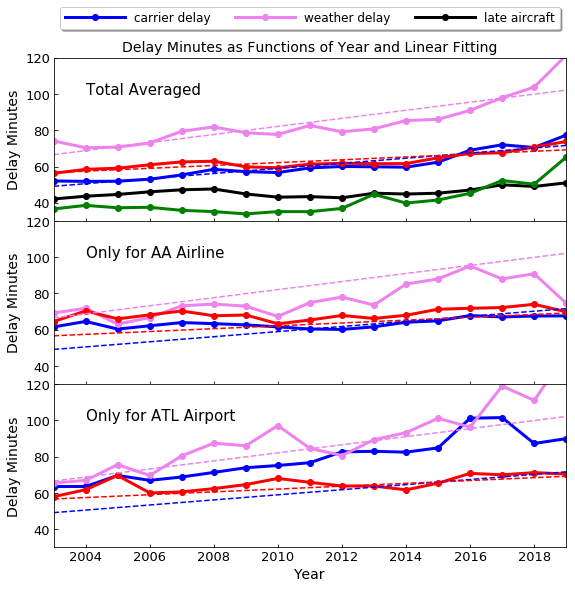

In [14]:
#year_delays

X1 = year_delays['year'].values
Y_delmin  = year_delays['arr_delay'].values/year_delays['arr_del15'].values
Ymin_carrier = year_delays['carrier_delay'].values/year_delays['carrier_ct'].values
Ymin_weather = year_delays['weather_delay'].values/year_delays['weather_ct'].values
Ymin_nas = year_delays['nas_delay'].values/year_delays['nas_ct'].values
Ymin_security = year_delays['security_delay'].values/year_delays['security_ct'].values
Ymin_latecraft = year_delays['late_aircraft_delay'].values/year_delays['late_aircraft_ct'].values

data_AA = data[data['carrier'].str.contains('AA')]
year_delays_AA = data_AA.groupby('year', as_index=False).sum()
Ymin_carrier_AA = year_delays_AA['carrier_delay'].values/year_delays_AA['carrier_ct'].values
Ymin_weather_AA = year_delays_AA['weather_delay'].values/year_delays_AA['weather_ct'].values
Ymin_latecraft_AA = year_delays_AA['late_aircraft_delay'].values/year_delays_AA['late_aircraft_ct'].values

data_ATL = data[data['airport'].str.contains('ATL')]
year_delays_ATL = data_ATL.groupby('year', as_index=False).sum()
Ymin_carrier_ATL = year_delays_ATL['carrier_delay'].values/year_delays_ATL['carrier_ct'].values
Ymin_weather_ATL = year_delays_ATL['weather_delay'].values/year_delays_ATL['weather_ct'].values
Ymin_latecraft_ATL = year_delays_ATL['late_aircraft_delay'].values/year_delays_ATL['late_aircraft_ct'].values


#linear = linear_model.LinearRegression()
#X_fit = year_delays.filter(regex='year').values
linear.fit(X_fit,Ymin_carrier)
Ymin_carrier_pred = linear.predict(X_fit)
print("Carrier Linear Score:", linear.score(X_fit,Ymin_carrier))
print("Carrier Linear AA Score:", linear.score(X_fit,Ymin_carrier_AA))
print("Carrier Linear ATL Score:", linear.score(X_fit,Ymin_carrier_ATL))

linear.fit(X_fit,Ymin_weather)
Ymin_weather_pred = linear.predict(X_fit)
print("\nWeather Linear Score:", linear.score(X_fit,Ymin_weather))
print("Weather Linear AA Score:", linear.score(X_fit,Ymin_weather_AA))
print("Weather Linear ATL Score:", linear.score(X_fit,Ymin_weather_ATL))

linear.fit(X_fit,Ymin_latecraft)
Ymin_latecraft_pred = linear.predict(X_fit)
print("\nLatecraft Linear Score:", linear.score(X_fit,Ymin_latecraft))
print("Latecraft Linear AA Score:", linear.score(X_fit,Ymin_latecraft_AA))
print("Latecraft Linear ATL Score:", linear.score(X_fit,Ymin_latecraft_ATL))

fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(311)

ax1.plot(X1,Ymin_carrier,'-o',linewidth=3,color='blue')
ax1.plot(X1,Ymin_weather,'-o',linewidth=3,color='violet')
ax1.plot(X1,Ymin_nas,'-o',linewidth=3,color='black')
ax1.plot(X1,Ymin_security,'-o',linewidth=3,color='green')
ax1.plot(X1,Ymin_latecraft,'-o',linewidth=3,color='red')
ax1.plot(X1,Ymin_carrier_pred,'--',linewidth=1.5,color='blue')
ax1.plot(X1,Ymin_weather_pred,'--',linewidth=1.5,color='violet')
ax1.plot(X1,Ymin_latecraft_pred,'--',linewidth=1.5,color='red')
ax1.tick_params(labelsize=13,direction='in')
ax1.legend(['carrier delay','weather delay','late aircraft'], 
           fontsize=12,handlelength=5,frameon=True,loc='upper center', bbox_to_anchor=(0.5, 1.35),
           fancybox=True, shadow=True, ncol=4)
plt.setp(ax1.get_xticklabels(),visible=False)
ax1.set_ylabel('Delay Minutes',fontsize=14)
ax1.set_xlim([2003,2019])
ax1.set_ylim([30,120])
plt.title('Delay Minutes as Functions of Year and Linear Fitting',fontsize=14)

plt.subplots_adjust(hspace=0)

ax2 = fig.add_subplot(312)

ax2.plot(X1,Ymin_carrier_AA,'-o',linewidth=3,color='blue')
ax2.plot(X1,Ymin_weather_AA,'-o',linewidth=3,color='violet')
ax2.plot(X1,Ymin_latecraft_AA,'-o',linewidth=3,color='red')
ax2.plot(X1,Ymin_carrier_pred,'--',linewidth=1.5,color='blue')
ax2.plot(X1,Ymin_weather_pred,'--',linewidth=1.5,color='violet')
ax2.plot(X1,Ymin_latecraft_pred,'--',linewidth=1.5,color='red')
ax2.tick_params(labelsize=13,direction='in')
plt.setp(ax2.get_xticklabels(),visible=False)
ax2.set_ylabel('Delay Minutes',fontsize=14)
ax2.set_xlim([2003,2019])
ax2.set_ylim([30,120])

ax3 = fig.add_subplot(313)

ax3.plot(X1,Ymin_carrier_ATL,'-o',linewidth=3,color='blue')
ax3.plot(X1,Ymin_weather_ATL,'-o',linewidth=3,color='violet')
ax3.plot(X1,Ymin_latecraft_ATL,'-o',linewidth=3,color='red')
ax3.plot(X1,Ymin_carrier_pred,'--',linewidth=1.5,color='blue')
ax3.plot(X1,Ymin_weather_pred,'--',linewidth=1.5,color='violet')
ax3.plot(X1,Ymin_latecraft_pred,'--',linewidth=1.5,color='red')
ax3.tick_params(labelsize=13,direction='in')
#plt.setp(ax3.get_xticklabels(),visible=False)
ax3.set_xlabel('Year',fontsize=14)
ax3.set_ylabel('Delay Minutes',fontsize=14)
ax3.set_xlim([2003,2019])
ax3.set_ylim([30,120])

ax1.annotate('Total Averaged', xy=(2004,100),fontsize=15)
ax2.annotate('Only for AA Airline', xy=(2004,100),fontsize=15)
ax3.annotate('Only for ATL Airport', xy=(2004,100),fontsize=15)

fig.subplots_adjust(left=0.08,right=0.97,bottom=0.05,top=0.9)


plt.show()

**Discussion for Delay Minutes:** 

This Figure shows that the average time of flight delays yearly. Unfortunately, all three panels show that the average delay duration increases with time. Linear regression is good to fit the average data (see the scores given by the averaged data). Although the probability of weather delay is much lower than carrier/nas/late-aircraft delays, the delay time is much longer than that of others. The AA delays due to weather condition are obviously shorter than the average delay time (the middle panel), while the ATL weather delay time is longer than the averaged data. 

Dose these results mean that the ATL weather is worse than the average weather condition in the US? Or maybe other reasons? We need more weather data to further explore the results. Nevertheless, the results from **Part 3** show that the averaged flight performance obtained from total data is obviously different from that given by individual airlines/airports. **If we would like to predict the flight performance, we need to predict it by airlines/airports individually.** Each airline or airport may give different prediction. 

Now let us go to the fourth part, to predict flight delays using supervised machine learning techniques. We divide this part into regression and classification problems.


##  Part 4. Supervised Regression and Classification for Individual Airport/Airline


In [15]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn import svm, gaussian_process
from sklearn.ensemble import RandomForestRegressor
#from sklearn.gaussian_process import GaussianProcessRegressor
#from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Machine Learning Models

models = {
        'Linear':linear_model.LinearRegression(),
        'Poly':PolynomialFeatures(degree=3),
        'Ridgereg':Ridge(alpha=0.1,normalize=True),
        'RandomForest':RandomForestRegressor(random_state=15,n_estimators=300),
        'SVM':svm.SVR(gamma='scale'),
        'BayesianRidge':linear_model.BayesianRidge(), 
        #'Gaussian':GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
       }

# Test Models

for n in range(2):
    if (n==0):
        train = data_ATL.filter(regex='year|month|arr_.*|.*_ct|.*_delay')
        AC = 'ATL Airport'
    else:
        train = data_AA.filter(regex='year|month|arr_.*|.*_ct|.*_delay')
        AC = 'AA Airline'
        
    train = train[train['year'] > 2002]
    train = train[train['month'] > 0]
    
    # rescale year and month using the preprocessing function
        
    train.year = train.year.astype(float)
    train.month = train.month.astype(float)
    train.year = preprocessing.scale(train.year)
    train.month = preprocessing.scale(train.month)
        
    # Add something interesting for regression
        
    train['delay_rate'] = train.arr_del15/train.arr_flights
    train['delay_min']  = train.arr_delay/train.arr_del15
    train.dropna(inplace = True)
    train = train[train['delay_rate'] < 1.0]
    
    if (n==0):
        print(train.head(5))
        print('\n')
        
    # Data for Training and Testing 
    
    train_X = train.filter(regex='year|month').values
    train_Y_rate = train.filter(regex='delay_rate').values
    train_Y_min = train.filter(regex='delay_min').values
        
    train_Y_rate = train_Y_rate.ravel()
    train_Y_min = train_Y_min.ravel()
        
    for model in models:
            
        X_train,X_test, Y_train, Y_test = train_test_split(train_X, train_Y_rate, 
                                                           test_size=0.3, random_state=42)
        if (model == 'Poly' or model == 'Ridgereg'):
            train_X_ = models['Poly'].fit_transform(train_X)
            X_train,X_test, Y_train, Y_test = train_test_split(train_X_, train_Y_rate, 
                                                               test_size=0.3, random_state=42)
        clf = models[model]
        if (model == 'Poly'):
            clf = models['Linear']
        clf.fit(X_train, Y_train)
            
        print(AC + ' '+ model + " Score: ", clf.score(X_test, Y_test))
    print('\n')

         year     month  arr_flights  arr_del15  carrier_ct  weather_ct  \
2   -1.684869 -0.157039        752.0      186.0       33.99       27.82   
133 -1.684869 -0.157039         90.0       16.0        3.09        0.00   
157 -1.684869 -0.157039        376.0       99.0       11.72        6.87   
324 -1.684869 -0.157039      15676.0     2660.0      444.42       81.77   
430 -1.684869 -0.157039       7139.0     1655.0      348.88      149.21   

      nas_ct  security_ct  late_aircraft_ct  arr_cancelled  arr_diverted  \
2     104.76         1.90             17.53            5.0           0.0   
133    10.55         0.74              1.61            0.0           0.0   
157    63.31         0.00             17.10            0.0           0.0   
324  1646.19         3.91            483.71           69.0          12.0   
430   788.07         9.92            358.92          118.0           5.0   

     arr_delay  carrier_delay  weather_delay  nas_delay  security_delay  \
2       8314.0   

**Comments:** 

We only consider the averaged delay rates as functions of years and months. Highlight the problem: Given two numbers: year and month, then I need to predict delay rates, in particular, for AA, and for ATL as case studies (similar question about predicting "delay minutes" can be asked). Note that I re-scale years and months.

In order to achieve this goal, we need to divide the overall data into training and testing datasets. I use **train_test_split** for that step. Then, several regression models are used for comparison: 

**Linear Regression**, **Polynomial Regression**, **Random Forest**, **Support Vector Machine (SVM)** , and **Bayesian**. Also **Regularization** is used for Polynomial Regression. 

Fitting processes are carried out using the training data, then each regression models are used to predict delay rates (**Y_pred**), and compared to **Y_test**. The scores are given above for each model. **We find that the best prediction is given by Random Forest, then by SVM**. For example, the accuracy score of Random Forest for AA Airline is 43%, which is significantly better than random guess. However, this accuracy is still not good enough. The next step is to adjust parameters (or say, parameter tuning). 


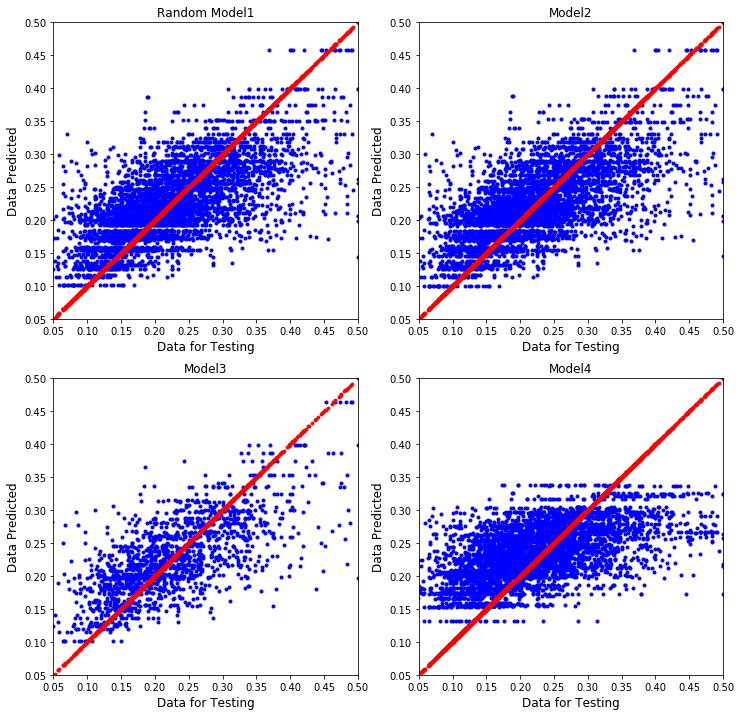

In [16]:
# The first try to tune parameters

RandomForest1 = RandomForestRegressor(random_state=15,n_estimators=300)
RandomForest2 = RandomForestRegressor(random_state=15,n_estimators=100)
SVM = svm.SVR(kernel='rbf', C=50,gamma='scale')

models = (RandomForest1,RandomForest2,RandomForest1,SVM)
titles = ('Random Model1','Model2','Model3','Model4')

fig = plt.figure(figsize=(12,12))
panels = [fig.add_subplot(221),fig.add_subplot(222),fig.add_subplot(223),fig.add_subplot(224)]

for clf, title, ax in zip(models, titles, panels):
    
    X_train,X_test, Y_train, Y_test = train_test_split(train_X, train_Y_rate, test_size=0.3, random_state=42)
    if (title == 'Model3'):
        X_train,X_test, Y_train, Y_test = train_test_split(train_X, train_Y_rate, test_size=0.1, random_state=42)
        
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    #print(clf.score(X_test,Y_test))
    ax.scatter(Y_test,Y_pred,s=9,color='blue')
    ax.scatter(Y_test,Y_test,s=8,color='red')
    ax.set_xlabel('Data for Testing',size=12)
    ax.set_ylabel('Data Predicted',size=12)
    ax.set_title(title,size=12)
    ax.set_xlim(0.05,0.5)
    ax.set_ylim(0.05,0.5)

plt.show()

**Discussion:**

The above figure visualizes the prediction based on various models. Ideally, if the prediction is exactly accurate, all dots should line up along the Data Test = Data Predicted line (red line). However, the scattering data shows the predicted data vs test data, which can show the accuracy of various predictions. The upper left and lower panels are for Random Forest Regression, but with different parameters **n_estimators**. No obviously difference is found. Then I increase the sample of training data, the score becomes higher, now goes to 50%. The lower right panel shows the performance of SVM, which is worse than that of Random Forest. 

At current stage, I can predict flight delays by the combination of year and month with a score of $\sim 50$%. In the last part I will discuss how to further improve the prediction. 


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

Logis = LogisticRegression(solver='sag',max_iter=100,multi_class='multinomial')

train = data_AA.filter(regex='year|month|arr_del15|arr_flights')
train = train[train['year'] > 2002]
train = train[train['month'] > 0]
train.year = train.year.astype(float)
train.month = train.month.astype(float)
train.year = preprocessing.scale(train.year)
train.month = preprocessing.scale(train.month)
train['delay_rate'] = train.arr_del15/train.arr_flights
train.dropna(inplace = True)

col         = 'delay_rate'
#conditions  = [ train[col] <=0.2, (train[col] >0.2) & (train[col]<= 0.25), train[col]> 0.25]
#choices     = [0, 1, 2]

conditions  = [ train[col] <=0.15, (train[col] >0.15) & (train[col]<= 0.20), 
               (train[col] >0.20) & (train[col]<= 0.25), train[col]> 0.25]
choices     = [0, 1, 2, 3]

train['class'] = np.select(conditions, choices, default=np.nan)
train['class'] = train['class'].astype(int)

#dummies_class = pd.get_dummies(train['class'], prefix= 'class')
#train = pd.concat([train, dummies_class], axis=1)

train.drop(['arr_flights','arr_del15','delay_rate'], axis=1, inplace=True)
train_X = train.filter(regex='year|month').values
train_Y = train.filter(regex='class').values
train_Y = train_Y.ravel()
        
X_train,X_test, Y_train, Y_test = train_test_split(train_X, train_Y, test_size=0.2)

Logis.fit(X_train, Y_train)
Y_pred_logis = Logis.predict(X_test)
print('Logitic Regression Score:', accuracy_score(Y_test, Y_pred_logis))

RandomClass = RandomForestClassifier(n_estimators=100,random_state=15,oob_score=True)
RandomClass.fit(X_train, Y_train)
Y_pred_random = RandomClass.predict(X_test)
print('RandomForest Classification Score:', accuracy_score(Y_test, Y_pred_random))

KNN = KNeighborsClassifier(n_neighbors=4)
KNN.fit(X_train, Y_train)
Y_pred_knn = KNN.predict(X_test)
print('KNN:', accuracy_score(Y_test, Y_pred_knn))

Decision = DecisionTreeClassifier(min_samples_split=3,random_state=45)
Decision.fit(X_train, Y_train)
Y_pred_decision = Decision.predict(X_test)
print('Decision Tree:', accuracy_score(Y_test, Y_pred_decision))

SVC = SVC(C=30,gamma='scale')
SVC.fit(X_train, Y_train)
Y_pred_svc = SVC.predict(X_test)
print('SVC:', accuracy_score(Y_test, Y_pred_svc))

Bagging = BaggingRegressor(Decision, n_estimators=30, max_samples=0.8, max_features=1.0, 
                           bootstrap=True, bootstrap_features=False, n_jobs=-1)
Bagging.fit(X_train, Y_train)
Y_pred_bagging = Bagging.predict(X_test)
Y_pred_bagging = Y_pred_bagging.round()
print('Decision + Bagging Score:', accuracy_score(Y_test, Y_pred_bagging))


Logitic Regression Score: 0.32405943724312364
RandomForest Classification Score: 0.47960796711982295
KNN: 0.43471387922858046
Decision Tree: 0.4770787227315839
SVC: 0.44166930129623777
Decision + Bagging Score: 0.4758141005374644


**Discussion:**

Now I sort delay rates into several groups/levels (see Part 2), and I would like to predict which level will a flight delay be depending on month and year. Again, the prediction is based on an individual airline (AA). In order to do that, supervised classifications are applied. 

I use **Logistic Regression**, **Random Forest**, **Decision Tree**, **SVC**, and also **Bagging** for multi-classification. Also data is divided into training and testing data. Scores are given using **accuracy_score** in sklearn. Now **Random Forest** and **Decision Tree** classifiers give best prediction, followed by **SVC**. 

I test several times, and find that the accuracy score is $\sim\,$48-50%. I will discuss how to improve the accuracy later. The next thing is to visualize the classification. 


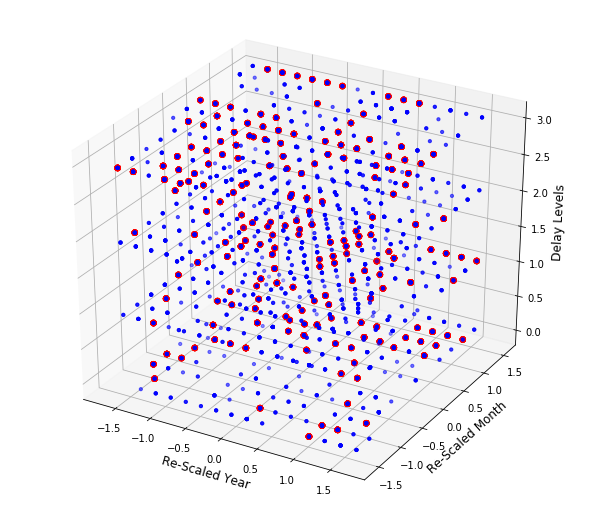

In [18]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,7))

ax = Axes3D(fig)
ax.set_xlabel('Re-Scaled Year',size=12)
ax.set_ylabel('Re-Scaled Month',size=12)
ax.set_zlabel('Delay Levels',size=12)

ax.scatter(X_test[:,0], X_test[:,1], Y_test, marker='o', s=10, color = 'blue')
ax.scatter(X_test[:,0], X_test[:,1], Y_pred_bagging, marker='o', s=30, color = 'red')

plt.show()

The X-axis is the rescaled years, and Y-axis is the rescaled months. Flight delays are given with different levels as Z-axis: 0, 1, 2 and 3. The blue dotts are from the testing data, while the red dotts are from the predicted data. The accuracy is about 50%.


## Part 5. Discussion and Future Work


There are many directions to extend the work and improve predictions. In Part 2, we can plot maps for a particular year instead of summation of all years, and see the evolution of flight performance yearly or monthly. In Part 3, I just pick up AA or ATL to compare with the averaged results, but other companies and airports (UA, ORG, etc) can be picked up for more interesting discussion. In Part 4 and Part 5, we can also discuss how to tune the parameters of regression/classification models more detailed. 

I believe the most important point for future work is to improve the prediction accuracy. So far the accuracy is $\sim 50\,$%, or even lower. 

**The very first attempt to improve the accuracy of the prediction, is to increase the sample of training data.** We already find that increasing the training sample can improve the accuracy slightly, but not significantly. But if we have much more data? The situation can be different.  

**The second attempt is to pre-process the training data.** So far I have not used cross-validation to evaluate qualitiy of predictions. **Cross validation** can be very useful to split the training data, and may improve the accuracy. 

**The third thing is to expand the data dimensions.** For example, so far I only use two dimensions (years and months) to predict flight delays, more information including flight dates, hours and other information are also needed for more accurate prediction. 

More data (**big data!**) can be obtained below, which is publicly-available online: 

https://transtats.bts.gov/ONTIME/Departures.aspx

The new data also includes dates, departure and arriving time, flight numbers, departure and arriving airports and so on. A set of training data with more dimensions/features will give better prediction. This direction can become my future work.


**The fourth thing is to use Deep Learning Methods.** So far I use machine learning techniques including supervised regression and classification, but more sophisticated deep learning methods (including CNN and RNN) may be applied to have a better prediction. In order to try this direction, **Tensorflow** and **Keras** instead of **scikit-learn** need to be used. A big question, again, is to optimaze parameters/layers. 


There are also many interesting questions behind the data phenomena. Some questions include:

**Why the AA NAS delay performance is below average, while the ATL NAS delay performance is significantly above average? Is there any correlation between late-aircraft delay (arriving delay) and departure delay? Any correlation between weather delay distribution and weather condition in the US? What are the differences between AA/UA, or ATL/ORG can tell us?** 

All of these questions need a more careful discussion, and extra data (for example, weather data), or more information about airport policy, social effect, and so on. 